# Import

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from pyproj import Transformer
import json
import re
from unidecode import unidecode

# Prepare GPS data

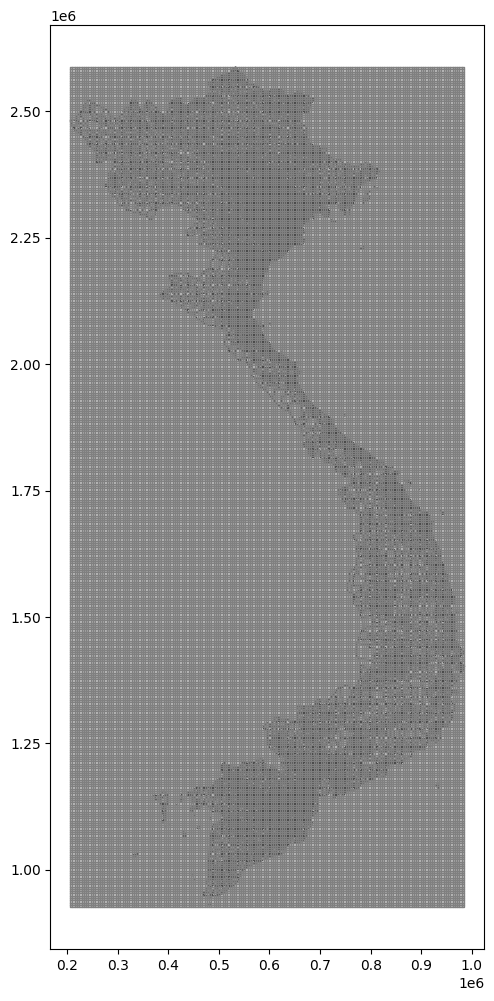

In [3]:
# Load the data from a JSON file
with open('large_files/gadm41_VNM_3.json', encoding='utf-8') as file:
    gadm = json.load(file)

# Normalize the JSON data into a pandas DataFrame
gps = pd.json_normalize(gadm['features'])

# Function to convert nested lists to MultiPolygon
def convert_to_multipolygon(nested_list):
    polygons = [Polygon(polygon[0]) for polygon in nested_list]
    return unary_union(polygons)

# Convert the 'geometry.coordinates' column to geometry
gps['geometry'] = gps['geometry.coordinates'].apply(convert_to_multipolygon)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(gps, geometry='geometry')
gdf.crs = "EPSG:4326"  # Set the coordinate reference system

# Reproject the GeoDataFrame to UTM
utm_crs = "EPSG:32648"  # UTM zone 48N for Vietnam
gdf_utm = gdf.to_crs(utm_crs)

# Get the bounds in the UTM coordinate system
bounds_utm = gdf_utm.total_bounds
minx, miny, maxx, maxy = bounds_utm

# Cell size in meters 
cell_size = 4500

# Calculate number of cells in x and y directions
num_cells_x = int((maxx - minx) / cell_size)
num_cells_y = int((maxy - miny) / cell_size)

# Create the grid cells
grid_cells = [box(minx + i * cell_size, miny + j * cell_size, 
                  minx + (i + 1) * cell_size, miny + (j + 1) * cell_size) 
              for i in range(num_cells_x) for j in range(num_cells_y)]

# Create a GeoDataFrame from the grid cells
grid_utm = gpd.GeoDataFrame(geometry=grid_cells)
grid_utm.crs = utm_crs

# Initialize the transformer to convert from UTM to WGS 84
transformer = Transformer.from_crs(utm_crs, "epsg:4326", always_xy=True)

# Analyze intersections and calculate centroids
results = []
for cell in grid_utm.geometry:
    centroid_utm = cell.centroid
    lon, lat = transformer.transform(centroid_utm.x, centroid_utm.y)
    intersected_wards = gdf_utm[gdf_utm.intersects(cell)]
    for idx, ward in intersected_wards.iterrows():
        intersection_area = cell.intersection(ward.geometry).area
        percent_coverage = intersection_area / cell.area
        results.append({
            'cell_id': cell.wkt,
            'province': ward['properties.NAME_1'],
            'district': ward['properties.NAME_2'],
            'ward': ward['properties.NAME_3'],
            'percent_coverage': percent_coverage,
            'centroid_longitude': lon,
            'centroid_latitude': lat
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
gdf_utm.plot(ax=ax, color='white', edgecolor='black')
grid_utm.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.show()

Cells can appear multiple time in the df. We should filter those cells that total land coverage is less 95%. (like those in the ocean)

In [5]:
# Group by cell id to find the total land coverage
total_land_coverage_by_cell = results_df.groupby(['cell_id'])['percent_coverage'].agg('sum')
cell_ids_with_large_coverage = total_land_coverage_by_cell[total_land_coverage_by_cell > 0.95].index.to_list()
results_df = results_df[results_df['cell_id'].isin(cell_ids_with_large_coverage)]

# results_df.to_csv('../data/ward_data.csv', index=False)
# results_df = pd.read_csv('../data/ward_data.csv')

## Inspection of cells

On average a cell contains 3.7 wards

In [136]:
unique_ward_count_by_cell = results_df.groupby('cell_id')['ward'].nunique()
max_unique_ward_count = unique_ward_count_by_cell.max()
cell_id_with_max_ward_count = unique_ward_count_by_cell.idxmax()

In [137]:
unique_ward_count_by_cell.describe()

count    17488.000000
mean         3.498056
std          2.297334
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         63.000000
Name: ward, dtype: float64

In [114]:
# Group by cell_id and count unique ward_id for each cell
unique_ward_count_by_cell = results_df.groupby('cell_id')['ward'].nunique()

# Find the cell_id with the maximum count of unique ward_ids
max_unique_ward_count = unique_ward_count_by_cell.max()
cell_id_with_max_ward_count = unique_ward_count_by_cell.idxmax()

In [115]:
results_df[results_df['cell_id']==cell_id_with_max_ward_count]

,cell_id,province,district,ward,percent_coverage,centroid_longitude,centroid_latitude
23394,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,BaĐình,CốngVị,0.000167,105.830548,21.012132
23395,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,BaĐình,ĐiệnBiên,0.019599,105.830548,21.012132
23396,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,BaĐình,GiảngVõ,0.030587,105.830548,21.012132
23397,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,BaĐình,KimMã,0.016703,105.830548,21.012132
23398,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,BaĐình,NgọcKhánh,0.028045,105.830548,21.012132
...,...,...,...,...,...,...,...
23452,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,ThanhXuân,KhươngTrung,0.041419,105.830548,21.012132
23453,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,ThanhXuân,NhânChính,0.024691,105.830548,21.012132
23454,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,ThanhXuân,PhươngLiệt,0.027573,105.830548,21.012132
23455,"POLYGON ((588563.1598511024 2321464.686800875,...",HàNội,ThanhXuân,ThanhXuânTrung,0.005126,105.830548,21.012132


# Prepare the ward code data

In [6]:
ward_code = pd.read_csv('./large_files/ward_code.csv')

def remove_administrative_terms(s):
    administrative_terms = ['\\(Xã\\)','\\(Thịtrấn\\)','Quận', 'Thành Phố', 'Huyện', 'Thị Xã', 'Tỉnh', 'Phường', 'Xã', 'Thị Trấn']
    for term in administrative_terms:
        s = re.sub(f'(?i){term}', '', s, flags=re.UNICODE)
    return s.strip()

def merge_words(s):
    return s.replace(' ','')

dfs = []
for year in ['2014','2019']:
    relevant_year = [col for col in ward_code.columns if col.endswith(year) and (col.startswith('ward') or col.startswith('distname') or col.startswith('provname'))]
    df = ward_code[relevant_year].copy()
    df.loc[:,'year'] = year
    if year == '2019':
        df.columns = ['provname','distname','id','wardname','year']
    else:
        df.columns = ['provname','distname','id','wardname','change','year']    
    dfs.append(df)

ward_code = pd.concat(dfs, ignore_index=True,axis=0)
ward_code.drop_duplicates(inplace=True)
ward_code.dropna(subset=['distname','provname','wardname'],inplace=True)

# remove admin terms, accents and spaces
ward_code['distname'] = ward_code['distname'].apply(remove_administrative_terms).apply(unidecode).apply(merge_words)
ward_code['provname'] = ward_code['provname'].apply(remove_administrative_terms).apply(unidecode).apply(merge_words)
ward_code['wardname'] = ward_code['wardname'].apply(remove_administrative_terms).apply(unidecode).apply(merge_words)

ward_code.drop_duplicates(subset=['provname', 'distname', 'wardname', 'year'], inplace=True)
ward_code['year'] = ward_code['year'].astype(int)
ward_code.drop(columns=['change'], inplace=True)

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_16240\3481160864.py:1: DtypeWarning: Columns (153) have mixed types. Specify dtype option on import or set low_memory=False.
  ward_code = pd.read_csv('./large_files/ward_code.csv')


# Merge data together

Merge ward code and calculated wi by id

In [7]:
wi = pd.read_csv('../data/ward_WI_unweightedPCA.csv')
df = wi.merge(ward_code, how='left', left_on=['maxa','year'], right_on=['id','year'])
df.drop(columns=['matinh','mahuyen','maxa','id'], inplace=True)

In [8]:
results_df['province'] = results_df['province'].apply(remove_administrative_terms).apply(unidecode)
results_df['district'] = results_df['district'].apply(remove_administrative_terms).apply(unidecode)
results_df['ward'] = results_df['ward'].apply(remove_administrative_terms).apply(unidecode)

In [9]:
df =df.merge(results_df, how='left', left_on=['provname','distname','wardname'], right_on=['province','district','ward'])
df.drop(columns = ['provname','distname','wardname'], inplace=True)

In [10]:
total_land_coverage_by_cell = df.groupby(['year','cell_id']).agg({'percent_coverage':'sum'})
index = total_land_coverage_by_cell[total_land_coverage_by_cell > 0.95].index.get_level_values(1).to_list()
df = df[df['cell_id'].isin(index)]

In [11]:
# Step 1: Calculate the weighted value for each row
df['weighted_value'] = df['mean_pos_WI'] * df['percent_coverage']

# Step 2 & 3: Group by 'year' and 'cell_id'
grouped = df.groupby(['year', 'cell_id']).agg(
    total_weighted_value=('weighted_value', 'sum'),
    total_coverage=('percent_coverage', 'sum'),
    centroid_longitude=('centroid_longitude', 'first'),
    centroid_latitude=('centroid_latitude', 'first')
)

# Step 4: Calculate the weighted average
grouped['wi'] = grouped['total_weighted_value'] / grouped['total_coverage']

grouped.drop(columns=['total_weighted_value','total_coverage'],inplace=True)

# Reset index if you want 'year' and 'cell_id' back as columns
grouped = grouped.reset_index()

In [202]:
# grouped.to_csv('../data/label.csv', index=False)

In [14]:
grouped

,year,cell_id,centroid_longitude,centroid_latitude,wi
0,2014,"POLYGON ((215063.1598511024 2469964.686800875,...",102.211997,22.331845,1.420250
1,2014,"POLYGON ((215063.1598511024 2474464.686800875,...",102.211188,22.372451,1.420250
2,2014,"POLYGON ((219563.1598511024 2465464.686800875,...",102.256438,22.291983,1.420250
3,2014,"POLYGON ((219563.1598511024 2469964.686800875,...",102.255644,22.332591,1.420250
4,2014,"POLYGON ((219563.1598511024 2474464.686800875,...",102.254848,22.373198,1.420250
...,...,...,...,...,...
29524,2019,"POLYGON ((971063.1598511024 1443964.686800875,...",109.320286,13.045969,2.775827
29525,2019,"POLYGON ((975563.1598511024 1425964.686800875,...",109.358841,12.882979,2.712235
29526,2019,"POLYGON ((975563.1598511024 1430464.686800875,...",109.359545,12.923553,2.692332
29527,2019,"POLYGON ((975563.1598511024 1434964.686800875,...",109.360251,12.964127,2.705230
